In [36]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import imutils
import shutil
from sklearn.utils import shuffle
import os

In [55]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(image, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 

    return new_image

In [56]:
TRINING_DIR = "C:\\Users\\X1\\Desktop\\master - S3\\image-mining\\data\\data\\Training"
TEST_DIR = "C:\\Users\\X1\\Desktop\\master - S3\\image-mining\\data\\data\\Testing"
image_size = 128
def readDataSet(dirr):
    data = []
    yes_path = os.path.join(dirr, "yes")
    for file in os.listdir(yes_path):
        image = cv2.imread(os.path.join(yes_path, file),cv2.IMREAD_GRAYSCALE)
        img = crop_brain_contour(image)
        img = cv2.resize(img,(image_size,image_size))
        data.append((img,1))
        
    no_path = os.path.join(dirr, "no")
    for f in os.listdir(no_path):
        image = cv2.imread(os.path.join(no_path, f),cv2.IMREAD_GRAYSCALE)
        img = crop_brain_contour(image)
        image = cv2.resize(img,(image_size,image_size))
        data.append((image,0))
      
    return data 
          
train_dataset  = shuffle(readDataSet(TRINING_DIR))
test_dataset = shuffle(readDataSet(TEST_DIR))
print("training dataset lenght : ",len(train_dataset) )
print("test dataset lenght : ",len(test_dataset) )
print("Images shape : ",train_dataset[1][0].shape)

training dataset lenght :  2953
test dataset lenght :  409
Images shape :  (128, 128)


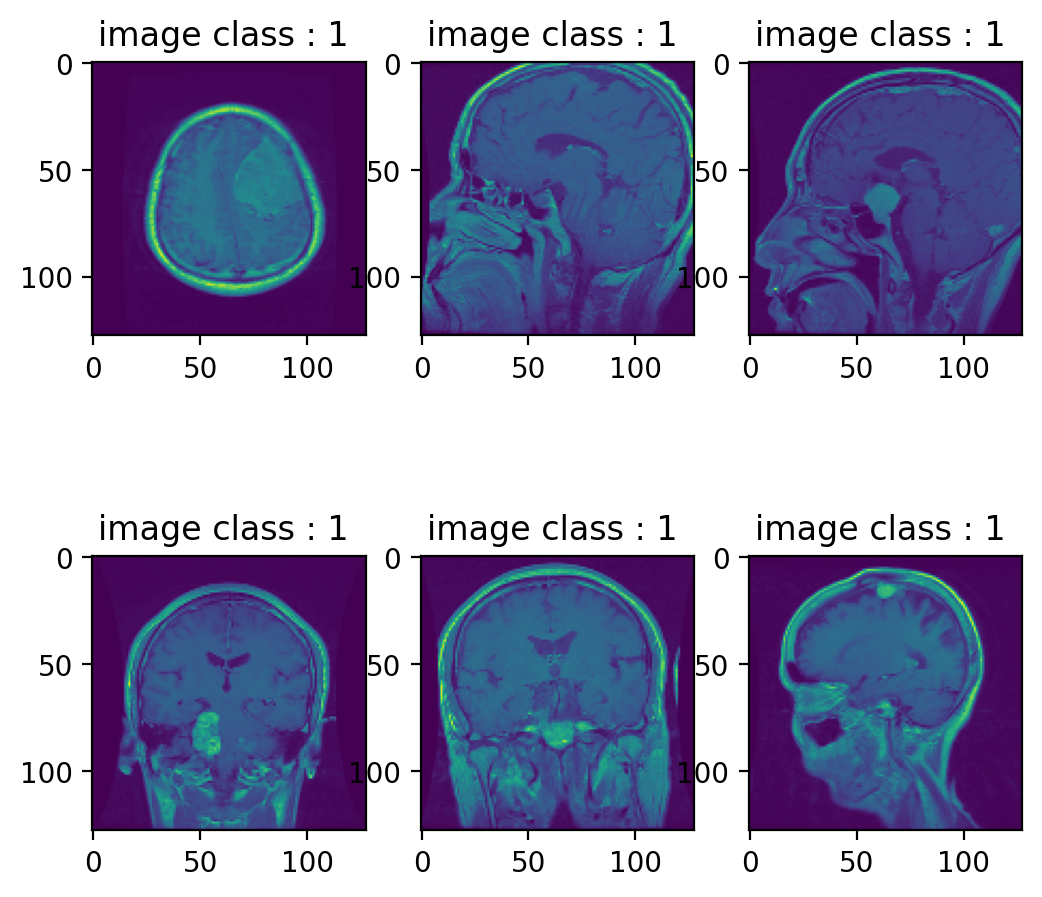

In [57]:
fig = plt.figure(figsize=(6, 6), dpi=200)
index = random.sample(range(len(images)), 6)
for i in range(6):
    ax1 = fig.add_subplot(2, 3, i+1)
    ax1.imshow(images[index[i]])
    ax1.set_title('image class : %s '% (labels[index[i]]))

In [58]:
import cv2 as cv

from skimage.feature.texture import greycomatrix , greycoprops
def  textureFeatures(img):
    GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    energy = greycoprops(GLCM, 'energy')[0, 0]
    corr = greycoprops(GLCM, 'correlation')[0, 0]
    homogen = greycoprops(GLCM, 'homogeneity')[0, 0]
    contrast = greycoprops(GLCM, 'contrast')[0, 0]
    
    features_texture = np.array([contrast,energy,homogen,corr])
    features_texture /= np.sum(features_texture,axis=0);
    return features_texture.reshape(-1)

#claculating the hog 
from skimage.feature import hog
import numpy as np
def hog_feature(img):
    fd, hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True)
    return hog_feature.reshape(-1)

from mahotas.features import haralick
import cv2 as cv
# bins for histogram
bins = 8

def fd_hu_moments(image):
    feature = cv.HuMoments(cv.moments(image)).flatten()
    feature /= np.mean(feature)
    return feature.reshape(-1)

# Haralick Texture
def fd_haralick(image):
    haralickF = haralick(image).mean(axis=0)
    return haralickF.reshape(-1)

from mahotas.features import surf
def surf_feature(img):
    fi = surf.integral(img.copy())
    points = surf.interest_points(fi, 6, 24, 1, max_points=1024, is_integral=True)
    descs = surf.descriptors(fi, points, is_integral=True, descriptor_only=True)
    return descs.reshape(-1)

In [73]:
#empty list for features 
def extractAllFeatures(dataset):
    X = []
    Y = []
    for i in range(len(dataset)):
        fv_haralick  = fd_haralick(dataset[i][0])
        fv_hu_moments = fd_hu_moments(dataset[i][0])
        fv_texture = textureFeatures(dataset[i][0])
        fv_hog = hog_feature(dataset[i][0])
        fv_surf = surf_feature(dataset[i][0])
        
        global_feature = np.hstack([fv_hu_moments,fv_haralick,fv_texture,fv_hog,fv_surf])
        
        X.append(global_feature)
        Y.append(dataset[i][1])
    return np.array(X),np.array(Y).reshape(-1) 


X_train , Y_train = extractAllFeatures(train_dataset)
X_test , Y_test = extractAllFeatures(test_dataset)
print("X_train : ", X_train.shape ," ,  Y_train : ", Y_train.shape)
print("X_test : ", X_test.shape," ,  Y_test : ", Y_test.shape)

X_train :  (2953, 16408)  ,  Y_train :  (2953,)
X_test :  (409, 16408)  ,  Y_test :  (409,)


In [74]:
########################### chi2 TEST ##########################
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def chi_square(X, y,nbf=500):
    ch2 = SelectKBest(chi2, k=nbf)
    my_transformed_matrix = ch2.fit_transform(X,y)
    return my_transformed_matrix
####################### LOG transformation ##################
import numpy as np
def Log_transform(mat):
    mat = mat - mat.min() + 1
    return np.log(mat)   
    
def zScore_Standarisation(xmat):
    ssX = StandardScaler()
    xmat = ssX.fit_transform(xmat)
    return xmat

def fillingEmptyValue(xmat):
    im = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value=None, verbose=0, copy=True)
    xmat = im.fit_transform(xmat)
    return xmat
X_train = fillingEmptyValue(X_train)
X_train = Log_transform(X_train)
X_test = fillingEmptyValue(X_test)
X_test = Log_transform(X_test)
print("X_train : ", X_train.shape ," ,  Y_train : ", Y_train.shape)
print("X_test : ", X_test.shape," ,  Y_test : ", Y_test.shape)

X_train :  (2953, 16408)  ,  Y_train :  (2953,)
X_test :  (409, 16408)  ,  Y_test :  (409,)


In [75]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, Y_train) 

y_pred = svclassifier.predict(X_test) 
######################## Evaluating the Algorithm ########################
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print("SVM accueacy : ",accuracy_score(Y_test,y_pred))

[[ 86  25]
 [ 64 234]]
              precision    recall  f1-score   support

           0       0.57      0.77      0.66       111
           1       0.90      0.79      0.84       298

    accuracy                           0.78       409
   macro avg       0.74      0.78      0.75       409
weighted avg       0.81      0.78      0.79       409

SVM accueacy :  0.78239608801956


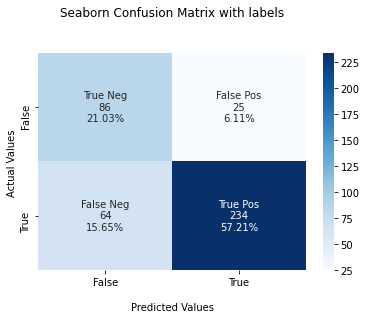

In [76]:
cf_matrix = confusion_matrix(Y_test, y_pred)
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()